# Initial Data Prep of Master Dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('Data/default of credit card clients.csv')
df.rename(columns={'Default':'default'}, inplace=True)

#set index to the "ID" value and remove the ID column
df.index = df.ID
del df['ID']

#Create Lists for Analysis
continuous_features = ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2','BILL_AMT3',
                       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
                       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
                       'PAY_AMT6']
ordinal_features = ['EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0','PAY_2', 'PAY_3',
                    'PAY_4', 'PAY_5', 'PAY_6','default']

#Convert datatypes
df[continuous_features] = df[continuous_features].astype(np.float64)
df[ordinal_features] = df[ordinal_features].astype(np.int64)

#convert any non-identified education categories to 'OTHER'
df['EDUCATION'] = df['EDUCATION'].replace(to_replace=(0,5,6),value=4)

#convert any non-identified marriage categories to 'OTHER'
df['MARRIAGE'] = df['MARRIAGE'].replace(to_replace=(0),value=3)

#Log transform continuous variables; as they each have a mostly 
##exponential distribution
df["log_LIMIT_BAL"]=np.log(df.LIMIT_BAL)
df["log_PAY_AMT1"]=np.log(df.PAY_AMT1+1)
df["log_PAY_AMT2"]=np.log(df.PAY_AMT2+1)
df["log_PAY_AMT3"]=np.log(df.PAY_AMT3+1)
df["log_PAY_AMT4"]=np.log(df.PAY_AMT4+1)
df["log_PAY_AMT5"]=np.log(df.PAY_AMT5+1)
df["log_PAY_AMT6"]=np.log(df.PAY_AMT6+1)

#Create a separate dataset with only useful variables as identified in Lab1 and Mini-lab1.
df = df[['SEX','EDUCATION','MARRIAGE','AGE', 'default'
            ,'PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5','PAY_6', "log_LIMIT_BAL"
            ,"log_PAY_AMT1","log_PAY_AMT2","log_PAY_AMT3","log_PAY_AMT4","log_PAY_AMT5"
            ,"log_PAY_AMT6"]]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 18 columns):
SEX              30000 non-null int64
EDUCATION        30000 non-null int64
MARRIAGE         30000 non-null int64
AGE              30000 non-null int64
default          30000 non-null int64
PAY_0            30000 non-null int64
PAY_2            30000 non-null int64
PAY_3            30000 non-null int64
PAY_4            30000 non-null int64
PAY_5            30000 non-null int64
PAY_6            30000 non-null int64
log_LIMIT_BAL    30000 non-null float64
log_PAY_AMT1     30000 non-null float64
log_PAY_AMT2     30000 non-null float64
log_PAY_AMT3     30000 non-null float64
log_PAY_AMT4     30000 non-null float64
log_PAY_AMT5     30000 non-null float64
log_PAY_AMT6     30000 non-null float64
dtypes: float64(7), int64(11)
memory usage: 4.3 MB


# Predicting Customer "Default"
I think it is easier to do the dependent variables seperately since we oversample with the default variable at first, so we are going to be working with a different dat set for this one.


### Default Specific data prep
##### Split data & over sample on the minority default class to help improve F1 statistic

In [2]:
# One-hot encoding of "EDUCATION" and "MARRIAGE".
tmp_df_1 = pd.get_dummies(df.EDUCATION,prefix='EDUCATION')
tmp_df_2 = pd.get_dummies(df.MARRIAGE,prefix='MARRIAGE')
dfsub1 = pd.concat((df,tmp_df_1,tmp_df_2),axis=1)
#Drop variables for which we used one-hot encoding
del dfsub1['EDUCATION']
del dfsub1['MARRIAGE']


split = np.random.rand(len(dfsub1)) < 0.8

df_train = dfsub1[split]
df_test = dfsub1[~split]

from sklearn.preprocessing import StandardScaler
# fit training for scaling after upsampling
X_train = df_train.drop(columns=['default']).values     
scl_obj = StandardScaler()
scl_obj.fit(X_train)

print("Dimensions of training data " , df_train.shape)
print("Dimensions of test are " , df_test.shape)

df_train.info()

Dimensions of training data  (23989, 23)
Dimensions of test are  (6011, 23)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23989 entries, 1 to 30000
Data columns (total 23 columns):
SEX              23989 non-null int64
AGE              23989 non-null int64
default          23989 non-null int64
PAY_0            23989 non-null int64
PAY_2            23989 non-null int64
PAY_3            23989 non-null int64
PAY_4            23989 non-null int64
PAY_5            23989 non-null int64
PAY_6            23989 non-null int64
log_LIMIT_BAL    23989 non-null float64
log_PAY_AMT1     23989 non-null float64
log_PAY_AMT2     23989 non-null float64
log_PAY_AMT3     23989 non-null float64
log_PAY_AMT4     23989 non-null float64
log_PAY_AMT5     23989 non-null float64
log_PAY_AMT6     23989 non-null float64
EDUCATION_1      23989 non-null uint8
EDUCATION_2      23989 non-null uint8
EDUCATION_3      23989 non-null uint8
EDUCATION_4      23989 non-null uint8
MARRIAGE_1       23989 non-null uint8
MAR

In [4]:
target_count = dfsub1.default.value_counts()
# Class count
df_class_0, df_class_1 = df_train.default.value_counts()

# Divide by class
df_class_0 = df_train[df_train['default'] == 0]
df_class_1 = df_train[df_train['default'] == 1]

df_class_1_over = df_class_1.sample(frac=target_count[0]/target_count[1], replace=True)
df_OverSampled = pd.concat([df_class_0, df_class_1_over], axis=0)
print('Random over-sampling:')
print(df_OverSampled.default.value_counts())


#Isolate the "default" variable into y and keep everythign else in X to use for predictions:
if 'default' in df_OverSampled:
    y_train = df_OverSampled['default'].values
    del df_OverSampled['default'] 
    X_train = df_OverSampled.values
    
if 'default' in df_test:
    y_test = df_test['default'].values
    del df_test['default'] 
    X_test = df_test.values

print("Dimensions of training features are " , X_train.shape)
print("Dimensions of training target are " , y_train.shape)
print("Dimensions of testing features are " , X_test.shape)
print("Dimensions of testing target are " , y_test.shape)

Random over-sampling:
0    18683
1    18681
Name: default, dtype: int64
Dimensions of training features are  (37364, 22)
Dimensions of training target are  (37364,)
Dimensions of testing features are  (6011, 22)
Dimensions of testing target are  (6011,)


##### apply scales to final training & test set to begin exploring models for Default

In [5]:
# use the previously fit scalines to transform the data after the over sampling
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)


## Insert model, visualizations, & interpretation for "Default Predictions here:

##### Code for accuracy plot

In [10]:
from matplotlib import pyplot as plt

def per_class_accuracy(ytrue,yhat):
    conf = mt.confusion_matrix(ytrue,yhat)
    norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    return np.diag(norm_conf)

def plot_class_acc(ytrue,yhat, title=''):
    acc_list = per_class_accuracy(ytrue,yhat)
    plt.bar(range(len(acc_list)), acc_list)
    plt.xlabel('Not Default and Default')
    plt.ylabel('Accuracy within class')
    plt.title(title+", Total Acc=%.1f"%(100*mt.accuracy_score(ytrue,yhat)))
    plt.grid()
    plt.show()
    

## Support Vector Machines

Accuracy: 0.764930959907
Confusion matrix:
[[3812  869]
 [ 544  786]]
f1_score: 0.526633165829
Precision: 0.474924471299
Recall: 0.590977443609


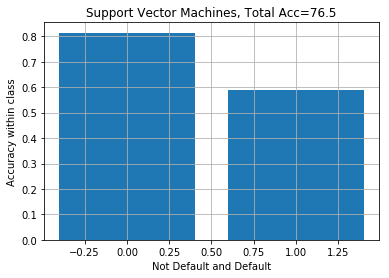

Wall time: 3min 14s


In [15]:
%%time
from sklearn.svm import SVC
from sklearn import metrics as mt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

# train the model
svm_clf = SVC(C=0.8, kernel='linear', degree=2, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

yhat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,yhat)
conf = mt.confusion_matrix(y_test,yhat)
print('Accuracy:', acc )
print('Confusion matrix:')
print(conf)
print('f1_score:', f1_score(y_test, yhat))
print('Precision:', precision_score(y_test, yhat))
print('Recall:', recall_score(y_test, yhat)) 
plot_class_acc(y_test,yhat,title="Support Vector Machines")

## KNN

KNN accuracy 0.694227250042
Confusion matrix:
[[3439 1242]
 [ 596  734]]
f1_score: 0.444041137326
Precision: 0.371457489879
Recall: 0.551879699248


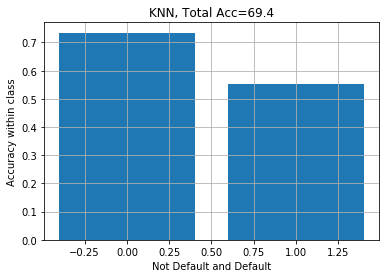

Wall time: 13.6 s


In [20]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


# get a handle to the classifier object, which defines the type
clf = KNeighborsClassifier(n_neighbors=3)

clf.fit(X_train_scaled,y_train)
yhat = clf.predict(X_test_scaled)

total_accuracy = mt.accuracy_score(y_test, yhat)
print ('KNN accuracy', total_accuracy)
conf = mt.confusion_matrix(y_test,yhat)
print('Confusion matrix:')
print(conf)
print('f1_score:', f1_score(y_test, yhat))
print('Precision:', precision_score(y_test, yhat))
print('Recall:', recall_score(y_test, yhat))
plot_class_acc(y_test,yhat,title="KNN")

## Random Forest

Accuracy 0.812344035934
Confusion matrix:
[[4318  363]
 [ 765  565]]
f1_score: 0.500442869796
Precision: 0.608836206897
Recall: 0.424812030075


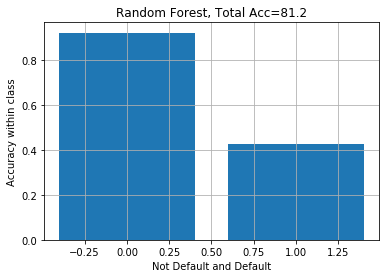

Wall time: 17.3 s


In [21]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

clf = RandomForestClassifier(max_depth=100, n_estimators=300, n_jobs=-1, oob_score=True)


clf.fit(X_train_scaled,y_train)
yhat = clf.predict(X_test_scaled)
    
total_accuracy = mt.accuracy_score(y_test, yhat)
print ('Accuracy', total_accuracy)
conf = mt.confusion_matrix(y_test,yhat)
print('Confusion matrix:')
print(conf)
print('f1_score:', f1_score(y_test, yhat))
print('Precision:', precision_score(y_test, yhat))
print('Recall:', recall_score(y_test, yhat)) 
plot_class_acc(y_test,yhat,title="Random Forest")

In [27]:
from astropy.table import Table, Column
import numpy as np
t = Table()
t['Method'] = ['Support Vector Machines', 'KNN', 'Random Forest']
t['Accuracy'] = [0.76, 0.69, 0.81]
t['f1_score'] = [0.52, 0.44, 0.50]
t['Recall'] = [0.59, 0.55, 0.42]
t['Time'] = ['3min 14s',' 13.6 s', '17.3 s']

print('Summary table:')

print(t)

Summary table:
         Method         Accuracy f1_score Recall   Time  
----------------------- -------- -------- ------ --------
Support Vector Machines     0.76     0.52   0.59 3min 14s
                    KNN     0.69     0.44   0.55   13.6 s
          Random Forest     0.81      0.5   0.42   17.3 s


Using F1 score and Recall rates we can say that Support Vector Machines provided the best results. The nehative side of this method that it takes to much time (3 min 14 sec). Lets review which attributes from Support Vector Machines model are most important.

log_PAY_AMT1 has weight of -0.217344501677
log_PAY_AMT3 has weight of -0.156622157777
log_PAY_AMT2 has weight of -0.152624478271
log_LIMIT_BAL has weight of -0.122295605769
log_PAY_AMT4 has weight of -0.110835697668
log_PAY_AMT5 has weight of -0.0718787941817
EDUCATION_4 has weight of -0.0662781598722
SEX has weight of -0.0457031324771
log_PAY_AMT6 has weight of -0.0422898500233
MARRIAGE_2 has weight of -0.0277667407951
MARRIAGE_3 has weight of -0.0210366211368
PAY_2 has weight of -0.0157559632379
EDUCATION_2 has weight of -0.00673739736294
EDUCATION_3 has weight of 0.00216782973104
PAY_4 has weight of 0.0160882057713
EDUCATION_1 has weight of 0.0227070496378
MARRIAGE_1 has weight of 0.0326090548536
PAY_6 has weight of 0.0503909773239
AGE has weight of 0.0810139176293
PAY_5 has weight of 0.100554915282
PAY_3 has weight of 0.168749425674
PAY_0 has weight of 0.610644357834


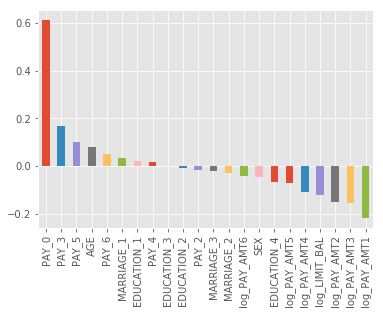

In [30]:
# sort these attributes and spit them out
A = dfsub1.drop(columns=['default'])
zip_vars = zip(svm_clf.coef_.T,A.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out
    
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = pd.Series(svm_clf.coef_[0],index=A.columns)
weights2 = weights.sort_values(ascending = False)
weights2.plot(kind='bar')
plt.show()    

# Predicting Education from Credit History

In [51]:
# perform one-hot encoding of the categorical data "EDUCATION" and "MARRIAGE".
tmp_df_2 = pd.get_dummies(df.MARRIAGE,prefix='MARRIAGE')
dfsub2 = pd.concat((df,tmp_df_2),axis=1)
del dfsub2['MARRIAGE']

from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'default' in dfsub2:
    y = dfsub2['EDUCATION'].values # get the labels we want
    del dfsub2['EDUCATION'] # get rid of the class label
    X = dfsub2.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 5
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=5, random_state=None, test_size=0.2, train_size=None)


In [53]:
from sklearn.preprocessing import StandardScaler

scl_obj = StandardScaler()

for train_indices, test_indices in cv_object.split(X,y): 
    
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
scl_obj.fit(X_train)

X_train_scaled = scl_obj.transform(X_train)
X_test_scaled = scl_obj.transform(X_test)

print("Dimensions of training features are " , X_train.shape)
print("Dimensions of training target are " , y_train.shape)
print("Dimensions of testing features are " , X_test.shape)
print("Dimensions of testing target are " , y_test.shape)

Dimensions of training features are  (24000, 19)
Dimensions of training target are  (24000,)
Dimensions of testing features are  (6000, 19)
Dimensions of testing target are  (6000,)


# Insert models for education here